<b>Tugas Praktikum Week 8</b> <br>
Jericho Cristofel Siahaya <br>
00000032932

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

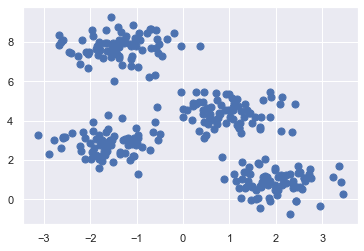

In [4]:
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50);

In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

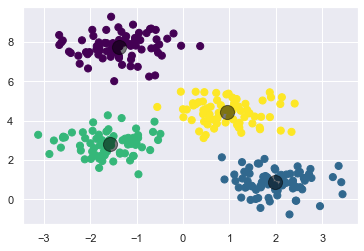

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

### k-Means Algorithm : Expectation-Maximization 

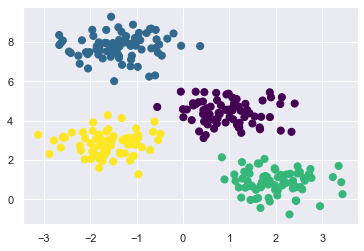

In [7]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Caveats of Expectation-Maximization

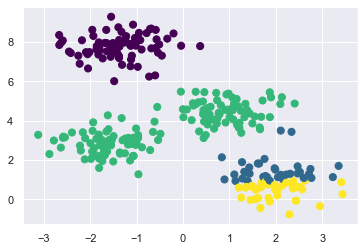

In [8]:
# random seeds make poor result
centers, labels = find_clusters(X, 4, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

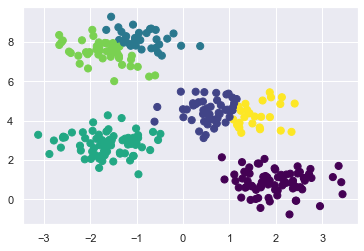

In [9]:
# must define number of cluster first
labels = KMeans(6, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

In [10]:
# limited to cluster boundaries, cant define good result when data has complicated geometries
from sklearn.datasets import make_moons
X, y = make_moons(200, noise=.05, random_state=0)

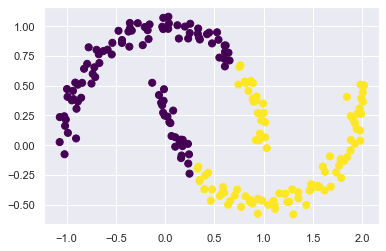

In [11]:
labels = KMeans(2, random_state=0).fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

C:\Users\laptop\anaconda3\envs\ml\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


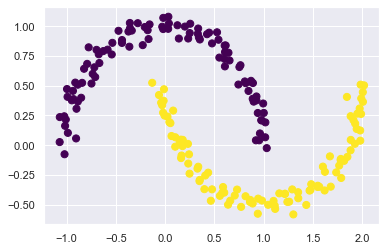

In [12]:
from sklearn.cluster import SpectralClustering
model = SpectralClustering(n_clusters=2, affinity='nearest_neighbors',
                           assign_labels='kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis');

### Implementation on digits data shape

In [13]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [14]:
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits.data)
kmeans.cluster_centers_.shape

(10, 64)

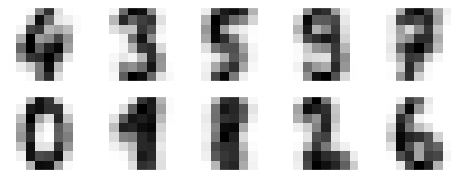

In [15]:
fig, ax = plt.subplots(2, 5, figsize=(8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for axi, center in zip(ax.flat, centers):
    axi.set(xticks=[], yticks=[])
    axi.imshow(center, interpolation='nearest', cmap=plt.cm.binary)

In [16]:
from scipy.stats import mode

labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

In [17]:
from sklearn.metrics import accuracy_score
accuracy_score(digits.target, labels)

0.7935447968836951

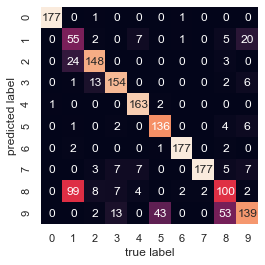

In [18]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(digits.target, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [19]:
from sklearn.manifold import TSNE

# Project the data: this step will take several seconds
tsne = TSNE(n_components=2, init='random', random_state=0)
digits_proj = tsne.fit_transform(digits.data)

# Compute the clusters
kmeans = KMeans(n_clusters=10, random_state=0)
clusters = kmeans.fit_predict(digits_proj)

# Permute the labels
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]

# Compute the accuracy
accuracy_score(digits.target, labels)

0.9348914858096828

### Implementation for Color Compression

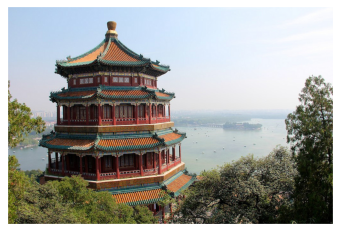

In [20]:
from sklearn.datasets import load_sample_image
china = load_sample_image("china.jpg")
ax = plt.axes(xticks=[], yticks=[])
ax.imshow(china);

In [21]:
china.shape

(427, 640, 3)

In [22]:
data = china / 255.0 # use 0...1 scale
data = data.reshape(427 * 640, 3)
data.shape

(273280, 3)

In [23]:
def plot_pixels(data, title, colors=None, N=10000):
    if colors is None:
        colors = data
    
    # choose a random subset
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    ax[0].scatter(R, G, color=colors, marker='.')
    ax[0].set(xlabel='Red', ylabel='Green', xlim=(0, 1), ylim=(0, 1))

    ax[1].scatter(R, B, color=colors, marker='.')
    ax[1].set(xlabel='Red', ylabel='Blue', xlim=(0, 1), ylim=(0, 1))

    fig.suptitle(title, size=20);

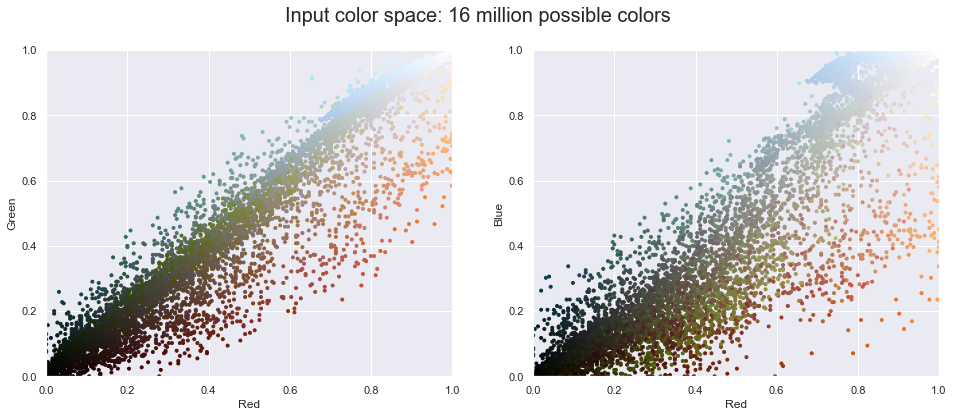

In [24]:
plot_pixels(data, title='Input color space: 16 million possible colors')

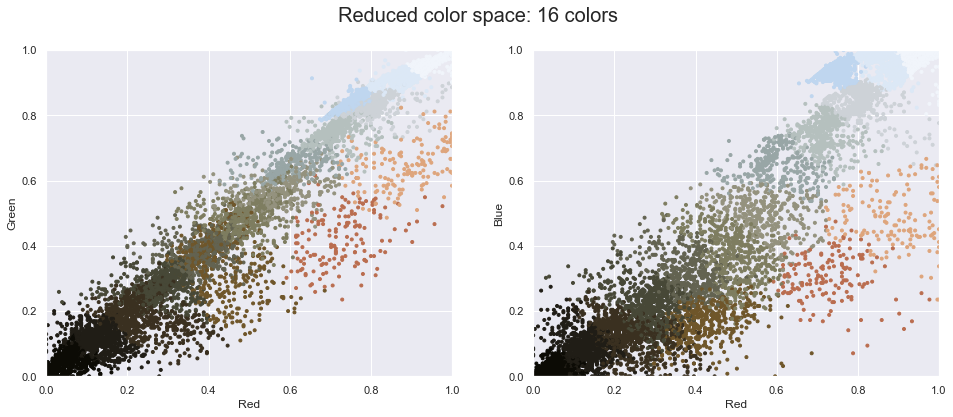

In [25]:
import warnings; warnings.simplefilter('ignore')  # Fix NumPy issues.

from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]

plot_pixels(data, colors=new_colors,
            title="Reduced color space: 16 colors")

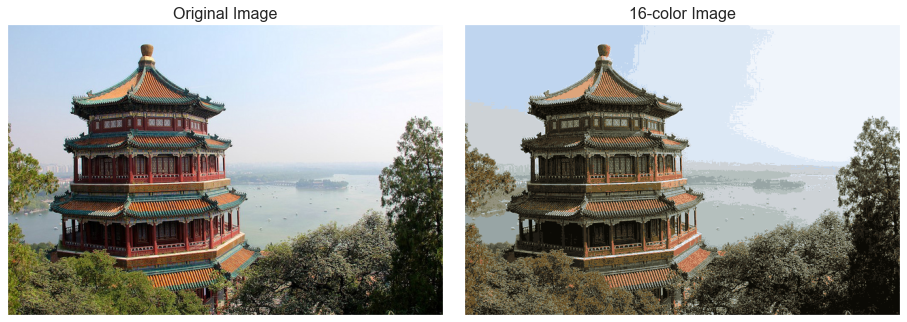

In [26]:
china_recolored = new_colors.reshape(china.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(xticks=[], yticks=[]))
fig.subplots_adjust(wspace=0.05)
ax[0].imshow(china)
ax[0].set_title('Original Image', size=16)
ax[1].imshow(china_recolored)
ax[1].set_title('16-color Image', size=16);

## k-Medoids Algorithm

In [35]:
#library lain sudah diimport di atas
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import datasets
from sklearn.decomposition import PCA

In [36]:
iris = datasets.load_iris()
data = pd.DataFrame(iris.data, columns = iris.feature_names)

target = iris.target_names
labels = iris.target

In [39]:
#scaling data
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data.head(10)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,0.222222,0.625000,0.067797,0.041667
1,0.166667,0.416667,0.067797,0.041667
2,0.111111,0.500000,0.050847,0.041667
3,0.083333,0.458333,0.084746,0.041667
4,0.194444,0.666667,0.067797,0.041667
5,0.305556,0.791667,0.118644,0.125000
6,0.083333,0.583333,0.067797,0.083333
7,0.194444,0.583333,0.084746,0.041667
8,0.027778,0.375000,0.067797,0.041667
9,0.166667,0.458333,0.084746,0.000000


There are 4 features which might not be ideal for visualization and fitting of the 
clustering model since some of them might be highly correlated. Therefore, we will
employ the Principal Component Analysis (PCA) to transform 4-dimensional data 
into 3-dimensional data while keeping the significance of those predictors with the 
PCA class from sklearn. 

In [40]:
pca = PCA(n_components=3)
principalComponents = pca.fit_transform(data)
PCAdf = pd.DataFrame(data=principalComponents, columns = ['principal component 1', 'principal component 2', 'principal component 3'])

datapoints = PCAdf.values
m, f = datapoints.shape
k = 3

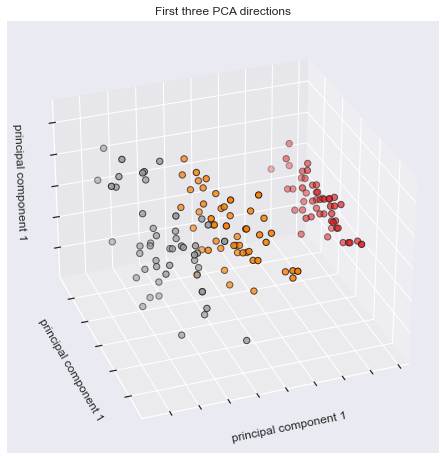

In [42]:
fig = plt.figure(1, figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)
X_reduced = datapoints
ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=labels,
           cmap=plt.cm.Set1, edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("principal component 1")
ax.w_xaxis.set_ticklabels([])
ax.set_ylabel("principal component 1")
ax.w_yaxis.set_ticklabels([])
ax.set_zlabel("principal component 1")
ax.w_zaxis.set_ticklabels([])
plt.show()

In [44]:
def init_medoids(X, k):
    from numpy.random import choice
    from numpy.random import seed
 
    seed(1)
    samples = choice(len(X), size=k, replace=False)
    return X[samples, :]

medoids_initial = init_medoids(datapoints, 3)

In [45]:
def compute_d_p(X, medoids, p):
    m = len(X)
    medoids_shape = medoids.shape
    # If a 1-D array is provided, 
    # it will be reshaped to a single row 2-D array
    if len(medoids_shape) == 1: 
        medoids = medoids.reshape((1,len(medoids)))
    k = len(medoids)
    
    S = np.empty((m, k))
    
    for i in range(m):
        d_i = np.linalg.norm(X[i, :] - medoids, ord=p, axis=1)
        S[i, :] = d_i**p

    return S
  
S = compute_d_p(datapoints, medoids_initial, 2)


In [46]:
def assign_labels(S):
    return np.argmin(S, axis=1)
  
labels = assign_labels(S)

In [47]:
def update_medoids(X, medoids, p):
    
    S = compute_d_p(datapoints, medoids, p)
    labels = assign_labels(S)
        
    out_medoids = medoids
                
    for i in set(labels):
        
        avg_dissimilarity = np.sum(compute_d_p(datapoints, medoids[i], p))

        cluster_points = datapoints[labels == i]
        
        for datap in cluster_points:
            new_medoid = datap
            new_dissimilarity= np.sum(compute_d_p(datapoints, datap, p))
            
            if new_dissimilarity < avg_dissimilarity :
                avg_dissimilarity = new_dissimilarity
                
                out_medoids[i] = datap
                
    return out_medoids

In [48]:
def has_converged(old_medoids, medoids):
    return set([tuple(x) for x in old_medoids]) == set([tuple(x) for x in medoids])

In [49]:
#Full algorithm
def kmedoids(X, k, p, starting_medoids=None, max_steps=np.inf):
    if starting_medoids is None:
        medoids = init_medoids(X, k)
    else:
        medoids = starting_medoids
        
    converged = False
    labels = np.zeros(len(X))
    i = 1
    while (not converged) and (i <= max_steps):
        old_medoids = medoids.copy()
        
        S = compute_d_p(X, medoids, p)
        
        labels = assign_labels(S)
        
        medoids = update_medoids(X, medoids, p)
        
        converged = has_converged(old_medoids, medoids)
        i += 1
    return (medoids,labels)

results = kmedoids(datapoints, 3, 2)
final_medoids = results[0]
data['clusters'] = results[1]

In [50]:
#Count
def mark_matches(a, b, exact=False):
    assert a.shape == b.shape
    a_int = a.astype(dtype=int)
    b_int = b.astype(dtype=int)
    all_axes = tuple(range(len(a.shape)))
    assert ((a_int == 0) | (a_int == 1) | (a_int == 2)).all()
    assert ((b_int == 0) | (b_int == 1) | (b_int == 2)).all()
    
    exact_matches = (a_int == b_int)
    if exact:
        return exact_matches

    assert exact == False
    num_exact_matches = np.sum(exact_matches)
    if (2*num_exact_matches) >= np.prod (a.shape):
        return exact_matches
    return exact_matches == False # Invert

In [51]:
def count_matches(a, b, exact=False):
    matches = mark_matches(a, b, exact=exact)
    return np.sum(matches)

n_matches = count_matches(labels, data['clusters'])
print(n_matches,
      "matches out of",
      len(data), "data points",
      "(~ {:.1f}%)".format(100.0 * n_matches / len(labels)))

142 matches out of 150 data points (~ 94.7%)


## k-Modes Algorithm : Unsupervised Learning for Categorical Data 

Download datasets: https://archive.ics.uci.edu/ml/datasets/bank+marketing

In [52]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pyplot import xticks

In [61]:
bank = pd.read_csv('bankmarketing.csv', sep=";")
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [62]:
bank.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

In [63]:
bank_cust = bank[['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']]

In [64]:
bank_cust.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,37,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,56,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent


In [65]:
bank_cust['age_bin'] = pd.cut(bank_cust['age'], [0,20,30,40,50,60,70,80,90,100], labels=['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80', '80-90', '90-100'])
bank_cust = bank_cust.drop('age', axis=1)

In [66]:
bank_cust.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,50-60
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,50-60
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,30-40
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,30-40
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,50-60


In [67]:
bank_cust.shape

(41188, 11)

In [68]:
bank_cust.describe()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
count,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188,41188
unique,12,4,8,3,3,3,2,10,5,3,9
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,30-40
freq,10422,24928,12168,32588,21576,33950,26144,13769,8623,35563,16385


In [69]:
bank_cust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   job          41188 non-null  object  
 1   marital      41188 non-null  object  
 2   education    41188 non-null  object  
 3   default      41188 non-null  object  
 4   housing      41188 non-null  object  
 5   loan         41188 non-null  object  
 6   contact      41188 non-null  object  
 7   month        41188 non-null  object  
 8   day_of_week  41188 non-null  object  
 9   poutcome     41188 non-null  object  
 10  age_bin      41188 non-null  category
dtypes: category(1), object(10)
memory usage: 3.2+ MB


In [70]:
bank_cust.isnull().sum()*100/bank_cust.shape[0]

job            0.0
marital        0.0
education      0.0
default        0.0
housing        0.0
loan           0.0
contact        0.0
month          0.0
day_of_week    0.0
poutcome       0.0
age_bin        0.0
dtype: float64

In [71]:
bank_cust_copy = bank_cust.copy()

In [72]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
bank_cust = bank_cust.apply(le.fit_transform)
bank_cust.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,3,1,0,0,0,0,1,6,1,1,4
1,7,1,3,1,0,0,1,6,1,1,4
2,7,1,3,0,2,0,1,6,1,1,2
3,0,1,1,0,0,0,1,6,1,1,2
4,7,1,3,0,0,2,1,6,1,1,4


In [73]:
!pip install kmodes

In [74]:
pip install --upgrade kmodes

Note: you may need to restart the kernel to use updated packages.


In [77]:
from kmodes.kmodes import KModes

In [86]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0


In [87]:
fitClusters_cao

array([1, 1, 0, ..., 0, 1, 0], dtype=uint16)

In [81]:
clusterCentroidsDf = pd.DataFrame(km_cao.cluster_centroids_)
clusterCentroidsDf.columns = bank_cust.columns

In [82]:
clusterCentroidsDf

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin
0,0,1,6,0,2,0,0,6,2,1,2
1,1,1,3,0,0,0,1,6,0,1,3


In [84]:
km_huang = KModes(n_clusters=2, init = "Huang", n_init = 1, verbose=1)
fitClusters_huang = km_huang.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 10006, cost: 200472.0
Run 1, iteration: 2/100, moves: 5963, cost: 196936.0
Run 1, iteration: 3/100, moves: 1510, cost: 196936.0


In [85]:
fitClusters_huang

array([1, 1, 0, ..., 0, 0, 0], dtype=uint16)

In [88]:
cost = []
for num_clusters in list(range(1,5)):
    kmode = KModes(n_clusters=num_clusters, init = "Cao", n_init = 1, verbose = 1)
    kmode.fit_predict(bank_cust)
    cost.append(kmode.cost_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 0, cost: 216952.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 4993, cost: 185138.0
Run 1, iteration: 2/100, moves: 1368, cost: 185138.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 6186, cost: 179774.0
Run 1, iteration: 2/100, moves: 1395, cost: 179774.0


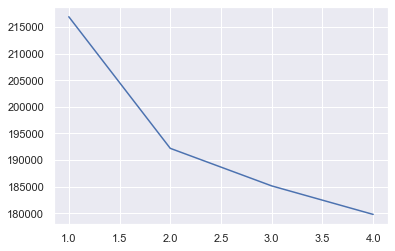

In [89]:
y = np.array([i for i in range(1,5,1)])
plt.plot(y,cost)

In [90]:
km_cao = KModes(n_clusters=2, init = "Cao", n_init = 1, verbose=1)
fitClusters_cao = km_cao.fit_predict(bank_cust)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 5322, cost: 192203.0
Run 1, iteration: 2/100, moves: 1160, cost: 192203.0


In [91]:
fitClusters_cao

array([1, 1, 0, ..., 0, 1, 0], dtype=uint16)

In [92]:
bank_cust = bank_cust_copy.reset_index()

In [94]:
clustersDf = pd.DataFrame(fitClusters_cao)
clustersDf.columns = ['cluster_predicted']
combinedDf = pd.concat([bank_cust, clustersDf], axis=1).reset_index()
combinedDf = combinedDf.drop(['index', 'level_0'], axis=1)

In [95]:
combinedDf.head()

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,age_bin,cluster_predicted
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent,50-60,1
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent,50-60,1
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent,30-40,0
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent,30-40,0
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent,50-60,1


In [96]:
cluster_0 = combinedDf[combinedDf['cluster_predicted'] == 0]
cluster_1 = combinedDf[combinedDf['cluster_predicted'] == 1]

In [97]:
cluster_0.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28293 entries, 2 to 41187
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   job                28293 non-null  object  
 1   marital            28293 non-null  object  
 2   education          28293 non-null  object  
 3   default            28293 non-null  object  
 4   housing            28293 non-null  object  
 5   loan               28293 non-null  object  
 6   contact            28293 non-null  object  
 7   month              28293 non-null  object  
 8   day_of_week        28293 non-null  object  
 9   poutcome           28293 non-null  object  
 10  age_bin            28293 non-null  category
 11  cluster_predicted  28293 non-null  uint16  
dtypes: category(1), object(10), uint16(1)
memory usage: 2.5+ MB


In [98]:
cluster_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12895 entries, 0 to 41186
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   job                12895 non-null  object  
 1   marital            12895 non-null  object  
 2   education          12895 non-null  object  
 3   default            12895 non-null  object  
 4   housing            12895 non-null  object  
 5   loan               12895 non-null  object  
 6   contact            12895 non-null  object  
 7   month              12895 non-null  object  
 8   day_of_week        12895 non-null  object  
 9   poutcome           12895 non-null  object  
 10  age_bin            12895 non-null  category
 11  cluster_predicted  12895 non-null  uint16  
dtypes: category(1), object(10), uint16(1)
memory usage: 1.1+ MB


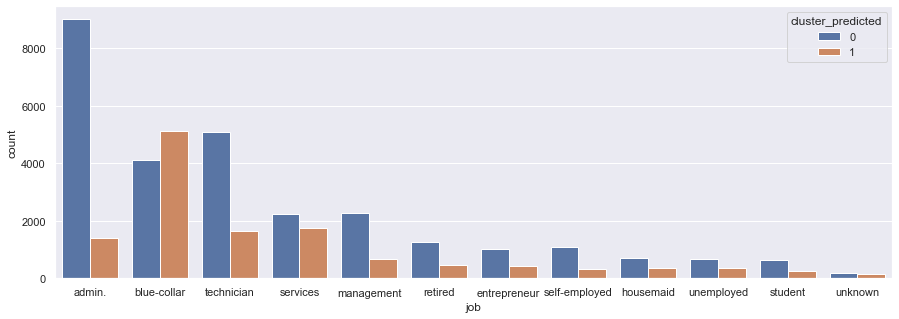

In [99]:
#Plotting based on attributes

#Job
plt.subplots(figsize=(15,5))
sns.countplot(x=combinedDf['job'], order=combinedDf['job'].value_counts().index, hue=combinedDf['cluster_predicted'])
plt.show()

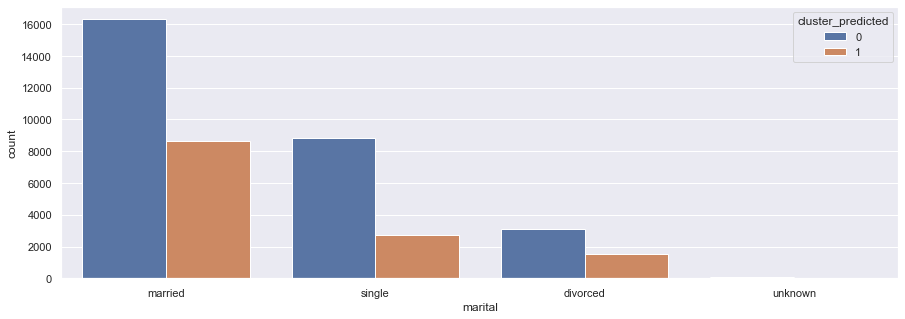

In [100]:
#Marital
plt.subplots(figsize=(15,5))
sns.countplot(x=combinedDf['marital'], order=combinedDf['marital'].value_counts().index, hue=combinedDf['cluster_predicted'])
plt.show()

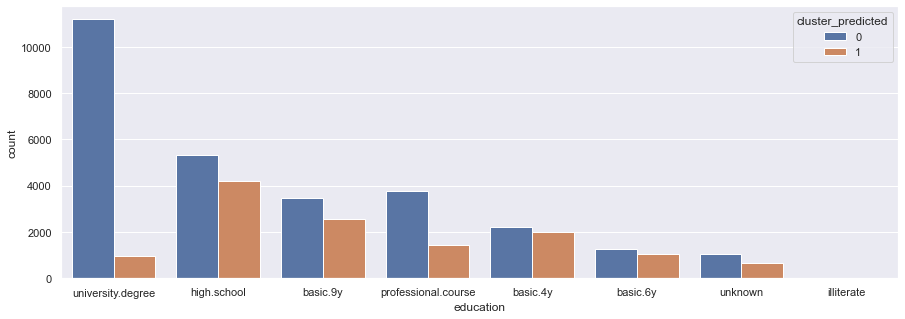

In [101]:
#Education
plt.subplots(figsize=(15,5))
sns.countplot(x=combinedDf['education'], order=combinedDf['education'].value_counts().index, hue=combinedDf['cluster_predicted'])
plt.show()

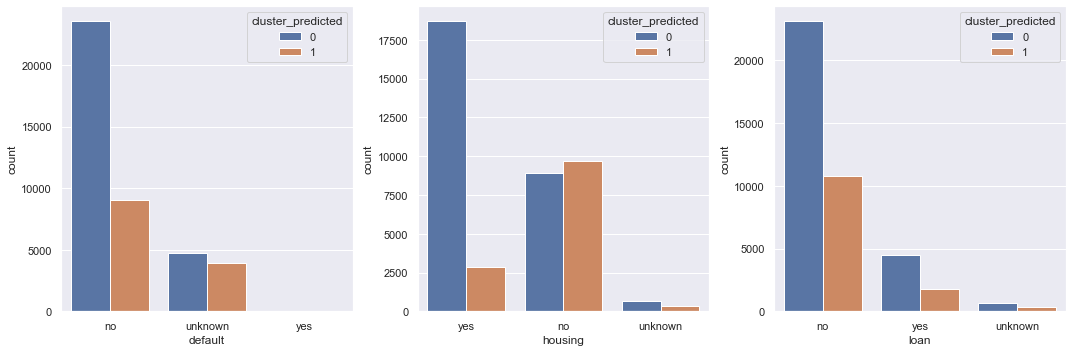

In [103]:
#Default
f, axs = plt.subplots(1,3,figsize=(15,5))
sns.countplot(x=combinedDf['default'],
             order=combinedDf['default'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['housing'],
             order=combinedDf['housing'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])
sns.countplot(x=combinedDf['loan'],
             order=combinedDf['loan'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[2])

plt.tight_layout()
plt.show()

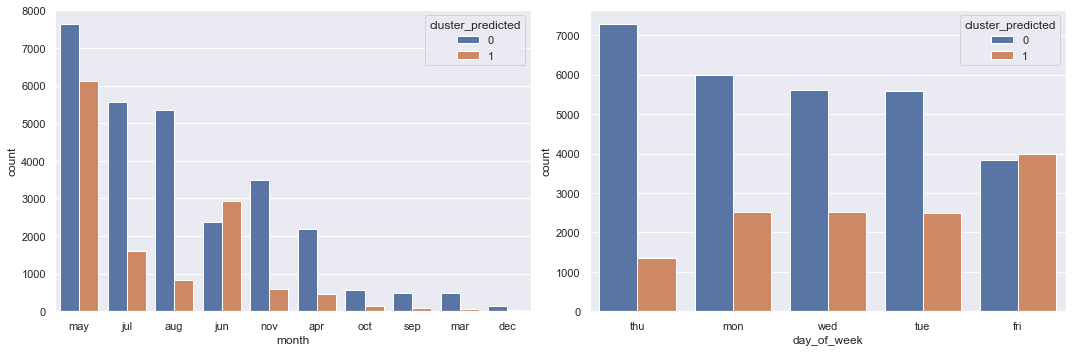

In [105]:
f, axs = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x=combinedDf['month'],
             order=combinedDf['month'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['day_of_week'],
             order=combinedDf['day_of_week'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])

plt.tight_layout()
plt.show()

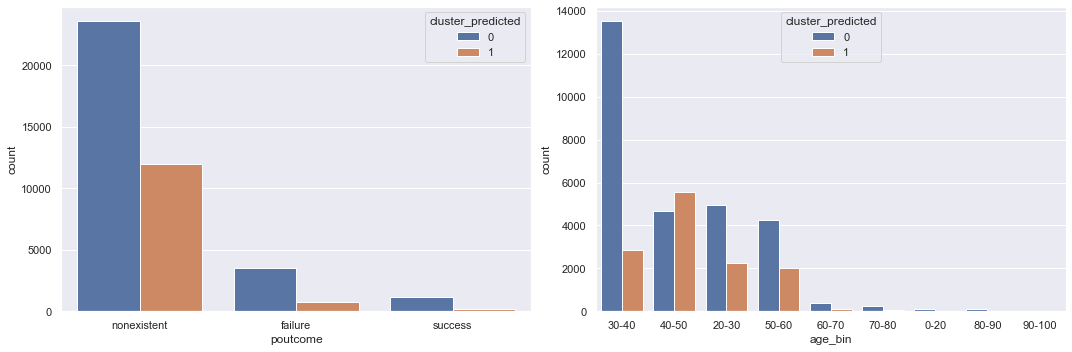

In [106]:
f, axs = plt.subplots(1,2,figsize=(15,5))
sns.countplot(x=combinedDf['poutcome'],
             order=combinedDf['poutcome'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[0])
sns.countplot(x=combinedDf['age_bin'],
             order=combinedDf['age_bin'].value_counts().index,hue=combinedDf['cluster_predicted'],ax=axs[1])

plt.tight_layout()
plt.show()